In [1]:
# Rafael Villca Poggian
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.style.use('fivethirtyeight')
# %matplotlib notebook

# Datos

Generaremos datos artificiales para ajustar una regresión lineal

In [3]:
β0 = -3
β1 = 10
# β0 = 500
# β1 = 87

m = 50
n = 2

X = np.sort(np.random.uniform(0, 10, m))
noise = np.random.normal(0, 10, m)
y = (β0 + β1*X)+noise

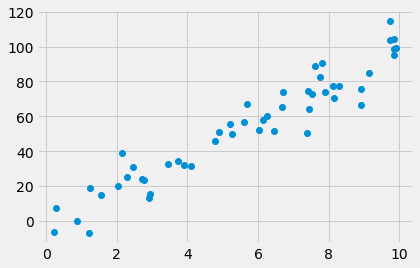

In [4]:
plt.plot(X, y, 'o')
plt.show()

In [5]:
# Agregamos una columna de unos para simplificar las formulas
Xcol = np.vstack((np.ones(len(X)), X)).T

# Ecuación Normal

Por mínimos cuadrados obtenemos la ecuación
$$\mathbf{\beta} = (\mathrm{X'}\cdot \mathrm{X})^{-1}\cdot \mathrm{X}' \cdot \mathbf{y}$$

In [6]:
params = np.linalg.inv(Xcol.T@Xcol)@Xcol.T@y
params = params.reshape(2, -1)
print(params)

[[-3.22908236]
 [10.15950294]]


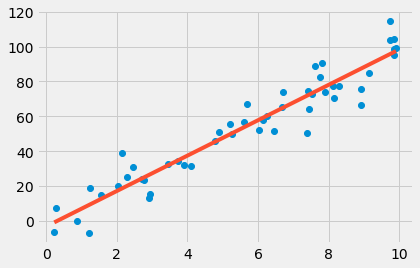

In [7]:
y_hat = (Xcol@params).ravel()

plt.plot(X, y, 'o')
plt.plot(X, y_hat)
plt.show()

# Descomposición QR

Al descomponer $\mathrm{X}$ de dimensiones $m\times n$, tendremos dos matrices $\mathrm{Q}$ y $\mathrm{R}$ con dimensiones $m\times m$ y $m\times n$ respectivamente

Si recortamos la columna de ceros de $\mathrm{R}$ nos quedaremos con una matriz de $n\times n$ y con $\mathrm{Q}$ de $m\times n$

In [8]:
Q, R = np.linalg.qr(Xcol, mode='complete')
print(f'Q:{Q.shape}, R:{R.shape}')

# Al diagonalizar R nos quedan entradas llenas de ceros, por lo tanto no requerimos más de dos colúmnas
print(R[:4, :])

Q1 = Q[:, :2]
R1 = R[:2, :]
print(f'Reducidos Q:{Q1.shape}, R:{R1.shape}')

Q:(50, 50), R:(50, 2)
[[ -7.07106781 -39.88268329]
 [  0.          20.56839777]
 [  0.           0.        ]
 [  0.           0.        ]]
Reducidos Q:(50, 2), R:(2, 2)


# Resolviendo para $\beta$

Al tener la ecuación
$$\mathrm{X}\cdot \mathbf{\beta} = \mathbf{y}$$

Si descomponemos $\mathrm{X}$ mediante $\mathrm{QR}$ reducido tedremos
$$\mathrm{Q}\cdot \mathrm{R}\cdot \mathbf{\beta} = \mathbf{y}$$

Debido a que $\mathrm{Q}$ es una matriz ortogonal $\mathrm{Q^{-1} = Q'}$
$$\mathrm{R}\cdot \mathbf{\beta} = \mathrm{Q'}\cdot \mathbf{y}$$

Si bien antes nuestro sistema de ecuaciones tenía dimensiones $m\times n$, ahora tendremos un sistema reducido para $\mathbf{y}$ arbitrario con dimensiones $n\times n$ siendo en este ejemplo de $2\times 2$

In [9]:
f = Q1.T@y

print('R1:\n', R1)
print()
print('f:\n', f.reshape(-1, 1))

R1:
 [[ -7.07106781 -39.88268329]
 [  0.          20.56839777]]

f:
 [[-382.35517767]
 [ 208.96469751]]


In [10]:
# Resolvemos por backsubstitution
n = len(R1)
params_qr = np.ones(n)

for i in reversed(range(n)):
    temp = 0
    for j in reversed(range(i+1, n-i)):
        temp += R[i, j]*params_qr[j]
    params_qr[i] = (f[i] - temp)/R[i,i]
    
print(params_qr)

[-3.22908236 10.15950294]


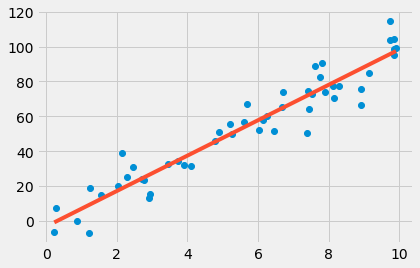

In [11]:
plt.plot(X, y, 'o')
plt.plot(X, Xcol@params_qr)
plt.show()

# Gradientes Conjugados

Este método nos permite iterativamente minimizar una función cuadrática de la forma:

$$\mathrm{F}(\mathbf{x}) = \frac{1}{2}\mathbf{x'}\cdot\mathrm{A}\cdot\mathbf{x}+\mathbf{b}\cdot\mathbf{x}+c$$
Cuyo gradiente es:

$$\nabla\mathrm{F}(\mathbf{x}) = \mathrm{A}\cdot \mathbf{x} + \mathbf{b}$$

Por tanto el mínimo se alcanza en $\nabla\mathrm{F}(\mathbf{x}) = 0$

Para resolver este sistema podríamos utilizar eliminación de Gauss, sin embargo cuando el sistema es muy grande la eliminación de Gauss se vuelve muy pesada de computar, sobre todo si la matriz es dispersa.

Para el caso de ajustar una regresión lineal por mínimos cuadrados, nuestra matriz de observaciones no será cuadrada sino que tendrá dimensiones $m\times n$ siendo $m$ el número de observaciones y $n$ el número de atributos.

Como para resolver mínimos cuadrados queremos minimizar la ecuación cuadrática:

$$\underset{\beta}{\arg\min}||\mathbf{y} - \mathrm{X}\cdot\mathbf{\beta}||^2 \implies \mathrm{G}(\mathbf{x}) = \frac{1}{2}\mathbf{\beta'}\mathrm{X'}\cdot\mathrm{X}\mathbf{\beta}-\mathbf{\beta'}\mathrm{X'}\mathbf{y}$$

Llegamos a la función $\mathrm{G}$ si sustituimos:
* $\mathrm{X'}\mathrm{X}\mathbf{\beta}$ en lugar de $\mathrm{A}\cdot\mathbf{x}$
* $\mathrm{X'}\mathbf{y}$ en lugar de $\mathbf{b}$
* $c$ será $0$ y cambiamos las $\mathbf{x}$ por $\beta$

Con el fin de minimizar la función necesitamos la derivada negativa direccional con respecto de $\beta$ para saber dónde está el mínimo:

$$\nabla\mathrm{G}(\mathbf{x}) = -\mathrm{X'}\cdot(\mathbf{y}-\mathrm{X}\mathbf{\beta}) = -\mathrm{X'}\mathbf{r}$$

Dónde $\mathbf{r}$ es el residuo.
La derivada direccional en cada iteración será:

$$\mathbf{g}_k = -\nabla\mathrm{G}(\mathbf{x_k}) = \mathrm{X'}\mathbf{r}$$

## Minimización

En cada iteración el método toma una dirección $\mathbf{p}$ conjugada a las anteriores direcciones tomadas en el espacio de los parámetros, de esta manera calcula la derivada y se mueve en esa dirección encontrando el mínimo en cada iteración para cada dimensión de los parámetros.

Debido a esto, como tenemos $n$ parámetros, el método convergerá al mínimo con aritmética exacta en $n$ iteraciones.

En cada iteración sólo es necesario multiplicar la matrix $\mathrm{X}$ por un vector $n$-dimensional y por otro vector $m$-dimensional una vez cada uno.

In [12]:
# Inicializamos los parámetros aleatoriamente
params_cg = np.random.randn(n)

print(f'parametros iniciales:{params_cg}')

parametros iniciales:[ 0.83994951 -0.49154065]


In [13]:
r = y - Xcol@params_cg
g = Xcol.T@r

# Guardamos el historial de movimientos de los parámetros
parameters_history = [[params_cg[0]], [params_cg[1]]]
error_history = [r.dot(r)]

# Para 2 parámetros sólo necesitamos 2 iteraciones.
for i in range(n):
    if np.linalg.norm(g) <= 1e-5:
        print('termino')
        break

    gdot = g.dot(g)
    
    if i == 0:
        p = g
    else:
        β = -gdot/g_prev.dot(g_prev)
        p = g - β*p

    C_dot_p = Xcol@p
    α = gdot/C_dot_p.dot(C_dot_p)
    
    params_cg = params_cg + α*p
    r = r - α*C_dot_p
    
    g_prev = g.copy()
    g = Xcol.T@r
    
    # Guardamos la posición actual
    parameters_history[0].append(params_cg[0])
    parameters_history[1].append(params_cg[1])
    error_history.append(r.dot(r))

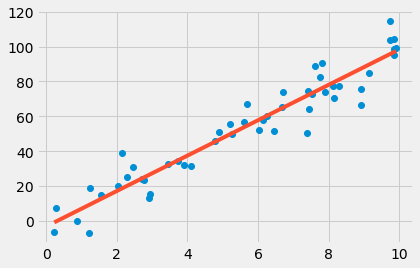

In [14]:
# Graficamos el modelo ajustado
plt.plot(X, y, 'o')
plt.plot(X, Xcol@params_cg)
plt.show()

# Gráfica de los parámetros

Visualizaremos cómo los parámetros se dirigen al mínimo.

Usaremos una gráfica de contorno, la cual representa una malla tridimensional proyectada en dos dimensiones, donde cada elipse representa un cambio de altitud considerable.

Como la función a optimizar es cuadrática, será un paraboloide, por lo cual el mínimo estará en el centro del paraboloide.

In [15]:
# Funcion del error para la gráfica
residual = lambda A, x, b: np.linalg.norm(b - A@x)**2

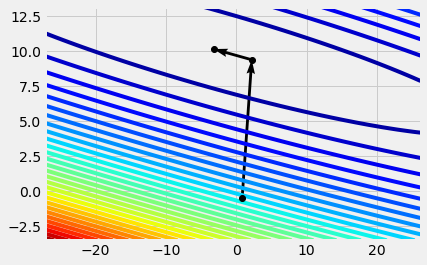

In [21]:
β0_hist, β1_hist = np.asarray(parameters_history)
angle_β0 = β0_hist[1:] - β0_hist[:-1]
angle_β1 = β1_hist[1:] - β1_hist[:-1]

offset = 3
T0, T1 = np.meshgrid(np.linspace(β0_hist.min()-offset*8, β0_hist.max()+offset*8, 100),
                     np.linspace(β1_hist.min()-offset, β1_hist.max()+offset, 100))

zs = np.array([residual(Xcol, [t0, t1], y) for t0, t1 in zip(np.ravel(T0), np.ravel(T1)) ] )  
Z = zs.reshape(T0.shape)

# %matplotlib inline
plt.contour(T0, T1, Z, 30, cmap='jet')
plt.plot(β0_hist, β1_hist, 'ko')
plt.quiver(β0_hist[:-1], β1_hist[:-1], angle_β0, angle_β1, scale_units='xy', angles='xy', scale=1)
plt.show()

## Gráfica Tridimensional

In [17]:
from mpl_toolkits.mplot3d import Axes3D

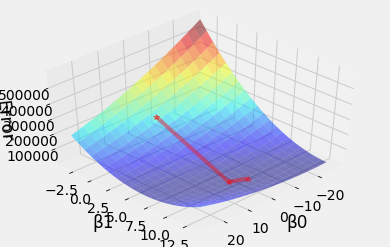

In [22]:
# %matplotlib inline
# fig = plt.figure(figsize = (16,8))
fig = plt.figure()

#Surface plot
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot_surface(T0, T1, Z, rstride = 5, cstride = 5, cmap = 'jet', alpha=0.5)
ax.plot(β0_hist, β1_hist, error_history, marker = '*', color = 'r', alpha = .4, label = 'Gradient descent')

ax.set_xlabel('β0')
ax.set_ylabel('β1')
ax.set_zlabel('Error')
ax.view_init(45, 45)